<a href="https://colab.research.google.com/github/aliakbarbadri/dogs-cats-classification/blob/master/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.applications import DenseNet169
import tensorflow_datasets as tfds
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files

https://www.kaggle.com/xhlulu/densenet-transfer-learning-iwildcam-2019

https://www.tensorflow.org/tutorials/images/transfer_learning

# Load the data

In [2]:
(raw_train, raw_valid, raw_test), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:60%]', 'train[60%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteIXIRNR/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [0]:
IMG_SIZE = 160
def resize_image(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [0]:
train = raw_train.map(resize_image)
valid = raw_valid.map(resize_image)
test = raw_test.map(resize_image)

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
valid_batches = valid.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [7]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

# Model

In [8]:
densenet = DenseNet169(include_top=False,input_shape=IMG_SHAPE,weights='imagenet')
densenet.trainable = False

51879936/51877672 [==============================] - 3s 0us/step


In [0]:
model = tf.keras.Sequential()
model.add(densenet) # (32, 5, 5, 1664)
model.add(tf.keras.layers.GlobalAveragePooling2D()) # (32, 1664)
model.add(tf.keras.layers.Dense(1)) # (32, 1)

In [11]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 5, 5, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 1,665
Non-trainable params: 12,642,880
_________________________________________________________________


In [12]:
history = model.fit(train_batches,epochs=10,validation_data=valid_batches)

Epoch 1/10
437/437 [==============================] - 80s 184ms/step - loss: 0.1995 - accuracy: 0.9205 - val_loss: 0.0749 - val_accuracy: 0.9738
Epoch 2/10
437/437 [==============================] - 76s 175ms/step - loss: 0.0649 - accuracy: 0.9780 - val_loss: 0.0515 - val_accuracy: 0.9812
Epoch 3/10
437/437 [==============================] - 76s 175ms/step - loss: 0.0522 - accuracy: 0.9811 - val_loss: 0.0441 - val_accuracy: 0.9838
Epoch 4/10
437/437 [==============================] - 76s 175ms/step - loss: 0.0467 - accuracy: 0.9832 - val_loss: 0.0404 - val_accuracy: 0.9847
Epoch 5/10
437/437 [==============================] - 76s 174ms/step - loss: 0.0432 - accuracy: 0.9844 - val_loss: 0.0385 - val_accuracy: 0.9862
Epoch 6/10
437/437 [==============================] - 76s 173ms/step - loss: 0.0409 - accuracy: 0.9851 - val_loss: 0.0371 - val_accuracy: 0.9874
Epoch 7/10
437/437 [==============================] - 76s 174ms/step - loss: 0.0391 - accuracy: 0.9862 - val_loss: 0.0353 - val_ac

In [13]:
model.evaluate(test_batches)

73/73 [==============================] - 8s 111ms/step - loss: 0.0423 - accuracy: 0.9854


[0.04234955459833145, 0.985382616519928]

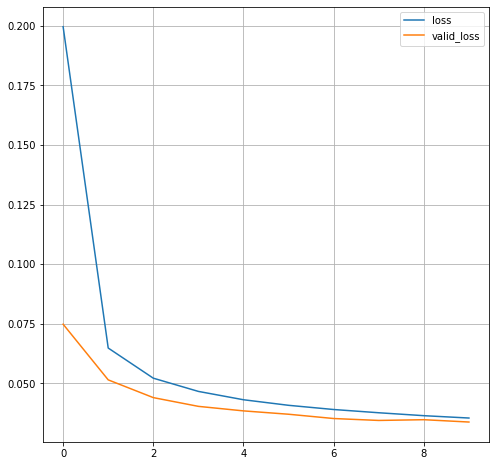

In [14]:
pd.DataFrame({'loss':history.history['loss'],
              'valid_loss':history.history['val_loss'],
              }).plot(figsize=(8, 8))
plt.grid(True)

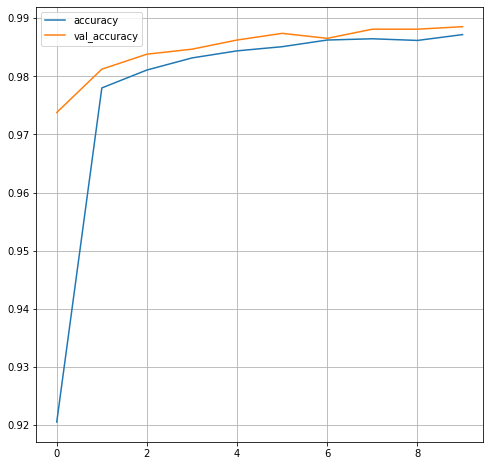

In [15]:
pd.DataFrame({'accuracy':history.history['accuracy'],
              'val_accuracy':history.history['val_accuracy']
              }).plot(figsize=(8, 8))
plt.grid(True)

In [0]:
model.save("densenet.h5")

#Fine tune

In [16]:
len(densenet.layers)

595

In [0]:
densenet.trainable = True
fine_tune_at = 550
for layer in densenet.layers[:fine_tune_at]:
  layer.trainable =  False

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.00001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 5, 5, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 1,438,273
Non-trainable params: 11,206,272
_________________________________________________________________


In [19]:
history_fine = model.fit(train_batches,
                         epochs=20,
                         initial_epoch =  history.epoch[-1],
                         validation_data=valid_batches)

Epoch 10/20
437/437 [==============================] - 83s 190ms/step - loss: 0.0554 - accuracy: 0.9828 - val_loss: 0.0373 - val_accuracy: 0.9878
Epoch 11/20
437/437 [==============================] - 81s 184ms/step - loss: 0.0435 - accuracy: 0.9842 - val_loss: 0.0334 - val_accuracy: 0.9887
Epoch 12/20
437/437 [==============================] - 81s 185ms/step - loss: 0.0387 - accuracy: 0.9860 - val_loss: 0.0316 - val_accuracy: 0.9891
Epoch 13/20
437/437 [==============================] - 80s 184ms/step - loss: 0.0379 - accuracy: 0.9856 - val_loss: 0.0304 - val_accuracy: 0.9897
Epoch 14/20
437/437 [==============================] - 82s 188ms/step - loss: 0.0332 - accuracy: 0.9870 - val_loss: 0.0297 - val_accuracy: 0.9900
Epoch 15/20
437/437 [==============================] - 80s 184ms/step - loss: 0.0316 - accuracy: 0.9877 - val_loss: 0.0291 - val_accuracy: 0.9904
Epoch 16/20
437/437 [==============================] - 80s 183ms/step - loss: 0.0268 - accuracy: 0.9908 - val_loss: 0.0287 -

In [20]:
model.evaluate(test_batches)

73/73 [==============================] - 7s 94ms/step - loss: 0.0352 - accuracy: 0.9854


[0.035201296210289, 0.985382616519928]

In [0]:
model.save("densenet_finetuned_45.h5")

In [0]:
# files.download("densenet_finetuned_45.h5")